# Import Section

In [44]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

from enum import Enum
from collections import namedtuple

import random
from collections import deque


# Image Processing Section

In [45]:
image_path = "dataset/moon/FRAME_1135_M.PNG"
image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

if len(image.shape) == 3:
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

## Visualize the processed image

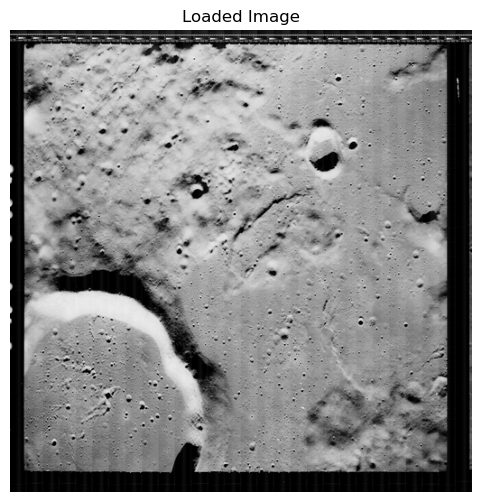

In [46]:
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.title("Loaded Image")
plt.show()

## Inspect the image pixels

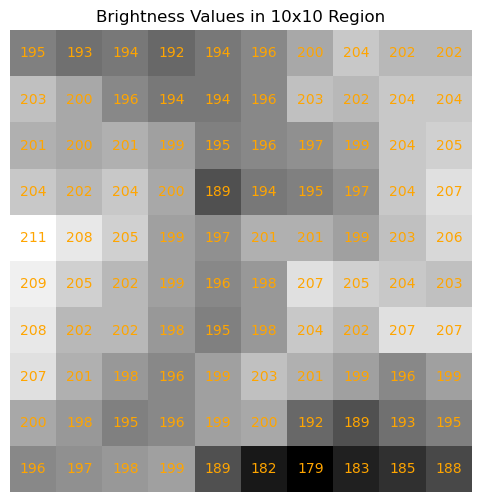

In [47]:
crop_size = 10

x_start = np.random.randint(0, image.shape[1] - crop_size + 1)
y_start = np.random.randint(0, image.shape[0] - crop_size + 1)

cropped_image = image[y_start:y_start+crop_size, x_start:x_start+crop_size]

h, w = cropped_image.shape

plt.figure(figsize=(6, 6))
plt.imshow(cropped_image, cmap="gray", interpolation="nearest")

for i in range(h):
    for j in range(w):
        plt.text(j, i, f"{cropped_image[i, j]}", ha="center", va="center", fontsize=10, color="orange")

plt.axis("off")
plt.title(f"Brightness Values in {crop_size}x{crop_size} Region")
plt.show()

## Generate 3-D plot to visualize the terrain

In [48]:
crop_size = 50

x_start = np.random.randint(0, image.shape[1] - crop_size + 1)
y_start = np.random.randint(0, image.shape[0] - crop_size + 1)

cropped_image = image[y_start:y_start + crop_size, x_start:x_start + crop_size]
grid = cropped_image / 255

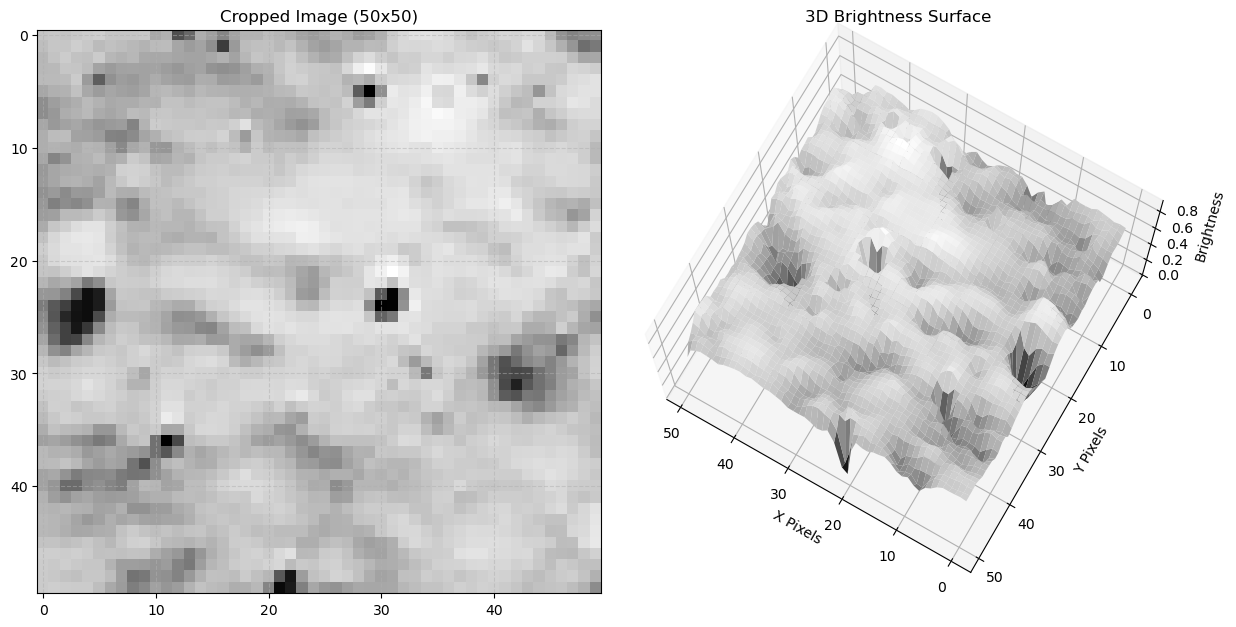

In [49]:
h, w = cropped_image.shape

x = np.arange(0, w, 1)
y = np.arange(0, h, 1)
X, Y = np.meshgrid(x, y)

Z = np.array(cropped_image, dtype=np.float32) / 255.0

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(cropped_image, cmap="gray", interpolation="nearest")
max_x, max_y = cropped_image.shape[1] - 1, cropped_image.shape[0] - 1
xticks = np.arange(0, max_x + 1, 5)
yticks = np.arange(0, max_y + 1, 5)
ax1.grid(True, linestyle="--", alpha=0.5)
ax1.set_title(f"Cropped Image ({crop_size}x{crop_size})")

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, Z, cmap='gray', edgecolor='none')

ax2.set_xlabel("X Pixels")
ax2.set_ylabel("Y Pixels")
ax2.set_zlabel("Brightness")
ax2.set_title("3D Brightness Surface")

ax2.view_init(elev=75, azim=120)

plt.tight_layout()
plt.show()


# RL Section

In [50]:
start = (10, 40)
goal = (20, 20)
checkpoints = [(30, 40), (38, 30), (35, 10), (20, 20)]

checkpoints

[(30, 40), (38, 30), (35, 10), (20, 20)]

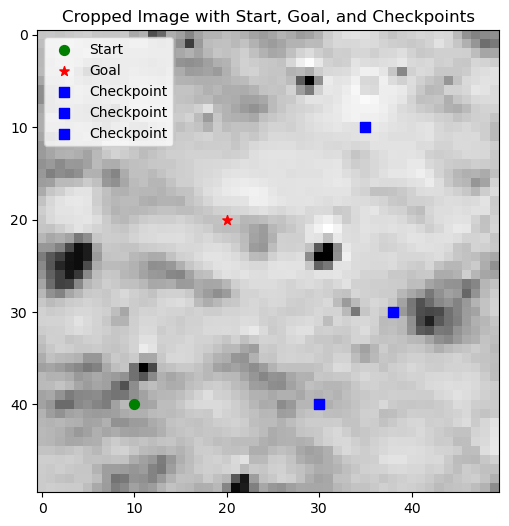

In [51]:
plt.figure(figsize=(6, 6))
plt.imshow(cropped_image, cmap="gray", interpolation="nearest")
plt.scatter(start[0], start[1], color="green", marker="o", s=50, label="Start")
plt.scatter(goal[0], goal[1], color="red", marker="*", s=50, label="Goal")
for _ in range(len(checkpoints)-1):
    plt.scatter(checkpoints[_][0], checkpoints[_][1], color="blue", marker="s", s=50, label="Checkpoint")
plt.title("Cropped Image with Start, Goal, and Checkpoints")
plt.legend()
plt.show()

## Define Action-Space

In [52]:
actions = {
    0: ( 0,  0),  # No movement
    1: (-1,  0),  # Up
    2: ( 1,  0),  # Down
    3: ( 0, -1),  # Left
    4: ( 0,  1),  # Right
    5: (-1, -1),  # Top-left
    6: (-1,  1),  # Top-right
    7: ( 1, -1),  # Bottom-left
    8: ( 1,  1)   # Bottom-right
}

## Linear Q-Net Model and QTrainer Architecture

In [53]:
class Linear_QNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # Define the first linear layer with input size and hidden size
        self.linear1 = nn.Linear(input_size, hidden_size)
        # Define the second linear layer with hidden size and output size
        self.linear2 = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        # Apply the first linear transformation followed by ReLU activation
        x = F.relu(self.linear1(x))
        # Apply the second linear transformation to produce the output
        x = self.linear2(x)
        return x


    def save(self, file_name='model.pth'):
        # Create a directory to save the model if it doesn't exist
        model_folder_path = './Model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        # Save the model state dictionary to the specified file
        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)


class QTrainer:

    def __init__(self, model, lr, gamma):
        # Learning rate for the optimizer
        self.lr = lr
        # Discount factor for future rewards
        self.gamma = gamma
        # Initialize the model
        self.model = model
        # Use Adam optimizer for training
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        # Mean Squared Error loss for training
        self.criterion = nn.MSELoss()


    def train_step(self, state, action, reward, next_state, done):
        # Convert numpy arrays to PyTorch tensors
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)

        # Check if the state has only one dimension (single instance)
        if len(state.shape) == 1:
            # Unsqueeze to add batch dimension
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )  # Convert to a tuple for consistency

        # 1: Get the predicted Q values for the current state
        pred = self.model(state)

        # Clone the predicted values to create the target Q values
        target = pred.clone()
        for idx in range(len(done)):
            # Calculate the new Q value from the reward
            Q_new = reward[idx]
            if not done[idx]:
                # If the state is not terminal, add discounted future reward
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            # Update the target for the action taken
            target[idx][torch.argmax(action[idx]).item()] = Q_new
    
        # 2: Perform a gradient descent step to minimize the loss
        self.optimizer.zero_grad()  # Clear previous gradients
        # Calculate the loss between target and predicted Q values
        loss = self.criterion(target, pred)
        loss.backward()  # Backpropagation to calculate gradients

        self.optimizer.step()  # Update the model parameters

## Rover Class

In [54]:
class Direction(Enum):
    UP = 1
    DOWN = 2
    LEFT = 3
    RIGHT = 4
    TOP_LEFT = 5
    TOP_RIGHT = 6
    BOTTOM_LEFT = 7
    BOTTOM_RIGHT = 8

Point = namedtuple('Point', 'x, y')

class Rover:
    def __init__(self, image, start, goal, checkpoints):
        self.h, self.w = image.shape
        self.start = Point(*start)  # Convert start tuple to Point
        self.final_goal = Point(*goal)  # Convert goal tuple to Point

        self.checkpoint_list = [Point(*p) if isinstance(p, tuple) else p for p in checkpoints]

        self.checkpoints = set(self.checkpoint_list)  # Convert to set for fast lookup
        self.goal = self.checkpoint_list[0] if self.checkpoint_list else self.final_goal  # Start with first checkpoint
        self.brightness_matrix = image.astype(np.float32) / 255.0
        self.reset()

    def __repr__(self):
        return "Classic"

    def reset(self):
        # Reset game state
        self.path = []
        self.checkpoints = set(self.checkpoint_list)  # Reset all checkpoints
        self.goal = self.checkpoint_list[0] if self.checkpoint_list else self.final_goal
        self.direction = Direction.DOWN
        self.head = Point(*self.start)
        self.curr_brightness = self.brightness_matrix[self.start[1], self.start[0]]
        self.prev_brightness = None

    def play_step(self, action):
        reward = -0.1  # Small step penalty
        goal_reached = False

        # Store previous brightness and position
        self.prev_brightness = self.curr_brightness
        temp_x, temp_y = self.head.x, self.head.y

        # Move the robot
        self._move(action)  

        # Ensure new position is within bounds
        if not (0 <= self.head.x < self.w and 0 <= self.head.y < self.h):
            reward -= 50  # Heavy penalty for going out of bounds
            self.head = Point(temp_x, temp_y)  # Reset to previous position
        else:
            self.curr_brightness = self.brightness_matrix[self.head.y, self.head.x]  # Extract brightness at new position

        # Check if the robot didn't move (invalid action)
        if self.head.x == temp_x and self.head.y == temp_y:
            reward -= 20  # Heavy penalty for staying in place

        # Brightness difference (height change)
        brightness_diff = self.curr_brightness - self.prev_brightness

        if brightness_diff > 0:  
            reward -= 5 * brightness_diff  # Penalize uphill movement (harder)
        elif brightness_diff < 0:
            reward -= 2 * abs(brightness_diff)  # Less penalty for downhill movement

        # Checkpoint reward and dynamic goal update
        if self.head in self.checkpoints:
            reward += 5  # Reward for reaching a checkpoint
            self.checkpoints.remove(self.head)  # Remove checkpoint after reaching

            # If there are remaining checkpoints, update goal to the next one
            if self.checkpoints:
                self.goal = min(self.checkpoints, key=lambda p: (p.x - self.head.x)**2 + (p.y - self.head.y)**2)
                print(f"New goal set: {self.goal}")
            else:
                self.goal = self.final_goal  # No more checkpoints, set goal to final destination
                print("All checkpoints cleared, heading to final goal!")

        # Final goal reward
        if self.head == self.final_goal:
            reward += 20
            goal_reached = True

        return reward, goal_reached

    def _move(self, action):
        clock_wise = [
            Direction.RIGHT, Direction.BOTTOM_RIGHT, Direction.DOWN, Direction.BOTTOM_LEFT,
            Direction.LEFT, Direction.TOP_LEFT, Direction.UP, Direction.TOP_RIGHT
        ]
        
        idx = clock_wise.index(self.direction)

        if np.array_equal(action, [1, 0, 0]):  # Continue straight
            new_dir = clock_wise[idx]
        elif np.array_equal(action, [0, 1, 0]):  # Turn right
            next_idx = (idx + 1) % 8
            new_dir = clock_wise[next_idx]
        else:  # [0, 0, 1] → Turn left
            next_idx = (idx - 1) % 8
            new_dir = clock_wise[next_idx]

        self.direction = new_dir

        x = self.head.x
        y = self.head.y

        # Move according to the new direction
        if self.direction == Direction.RIGHT:
            x += 1
        elif self.direction == Direction.LEFT:
            x -= 1
        elif self.direction == Direction.DOWN:
            y += 1
        elif self.direction == Direction.UP:
            y -= 1
        elif self.direction == Direction.TOP_LEFT:
            x -= 1
            y -= 1
        elif self.direction == Direction.TOP_RIGHT:
            x += 1
            y -= 1
        elif self.direction == Direction.BOTTOM_LEFT:
            x -= 1
            y += 1
        elif self.direction == Direction.BOTTOM_RIGHT:
            x += 1
            y += 1

        # Ensure robot doesn't go out of bounds
        if 0 <= x < self.w and 0 <= y < self.h:
            self.head = Point(x, y)


## Train the agent to move in environment safely

In [55]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

class Agent:
    # Agent class
    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 # randomness
        self.gamma = 0.9 # discount rate
        self.memory = deque(maxlen=MAX_MEMORY) # popleft()
        self.model = Linear_QNet(12, 256, 3)

        # Define the model path
        model_path = r'model\Classic Model.pth'

        # Check if the file exists before loading
        if os.path.exists(model_path):
            self.model.load_state_dict(torch.load(model_path, weights_only=True),)
            print("Model loaded successfully.")
        else:
            print("Model file not found. Initializing with default weights.")

        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)


    def get_state(self, game):
        # get current state
        head = game.head

        # Convert set to list and get the first checkpoint
        checkpoint = list(game.checkpoints)[0] if game.checkpoints else game.goal
        
        dir_l  = game.direction == Direction.LEFT
        dir_r  = game.direction == Direction.RIGHT
        dir_u  = game.direction == Direction.UP
        dir_d  = game.direction == Direction.DOWN
        dir_tl = game.direction == Direction.TOP_LEFT
        dir_tr = game.direction == Direction.TOP_RIGHT
        dir_bl = game.direction == Direction.BOTTOM_LEFT
        dir_br = game.direction == Direction.BOTTOM_RIGHT

        state = [
            # Move direction
            dir_l,
            dir_r,
            dir_u,
            dir_d,
            dir_tl,
            dir_tr,
            dir_bl,
            dir_br,
            
            # goal location 
            checkpoint[0] < head.x,  # goal left
            checkpoint[0] > head.x,  # goal right
            checkpoint[1] < head.y,  # goal up
            checkpoint[1] > head.y  # goal down
        ]

        return np.array(state)


    def remember(self, state, action, reward, next_state, done):
        # remember previous states
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached


    def train_long_memory(self):
        # train agent from previous long memory
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)
        #for state, action, reward, nexrt_state, done in mini_sample:
        #    self.trainer.train_step(state, action, reward, next_state, done)


    def train_short_memory(self, state, action, reward, next_state, done):
        # train agent from previous short memory
        self.trainer.train_step(state, action, reward, next_state, done)


    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 80 - self.n_games
        final_move = [0,0,0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move
    
path = []

def train():
    # start training the agent
    global path
    agent = Agent()
    game = Rover(cropped_image, start, goal, checkpoints)
    while agent.n_games <= 75:
        # get old state
        state_old = agent.get_state(game)

        # get move
        final_move = agent.get_action(state_old)

        # perform move and get new state
        reward, done = game.play_step(final_move)
        state_new = agent.get_state(game)

        game.path.append(game.head)
        #print(game.head)
        
        # train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # remember
        agent.remember(state_old, final_move, reward, state_new, done)

        if done:
            if not game.checkpoints:
                if(agent.n_games == 0):
                    path = game.path
                if(len(path) > len(game.path)):
                    path = game.path

            agent.n_games += 1
            print('Game', agent.n_games, 'path length:', len(game.path))
            print(game.checkpoints)
            
            game.reset()
            agent.train_long_memory()

train()

Model file not found. Initializing with default weights.
New goal set: Point(x=20, y=20)
New goal set: Point(x=38, y=30)
New goal set: Point(x=20, y=20)
All checkpoints cleared, heading to final goal!
Game 1 path length: 8701
set()
New goal set: Point(x=30, y=40)
New goal set: Point(x=20, y=20)
New goal set: Point(x=30, y=40)
Game 2 path length: 1328
{Point(x=30, y=40)}
New goal set: Point(x=30, y=40)
New goal set: Point(x=20, y=20)
New goal set: Point(x=30, y=40)
Game 3 path length: 2780
{Point(x=30, y=40)}
New goal set: Point(x=35, y=10)
Game 4 path length: 512
{Point(x=38, y=30), Point(x=35, y=10), Point(x=30, y=40)}
New goal set: Point(x=35, y=10)
Game 5 path length: 544
{Point(x=38, y=30), Point(x=35, y=10), Point(x=30, y=40)}
New goal set: Point(x=30, y=40)
New goal set: Point(x=20, y=20)
New goal set: Point(x=30, y=40)
Game 6 path length: 1587
{Point(x=30, y=40)}
New goal set: Point(x=30, y=40)
New goal set: Point(x=20, y=20)
New goal set: Point(x=30, y=40)
Game 7 path length: 2

## Visualize the path of the rover

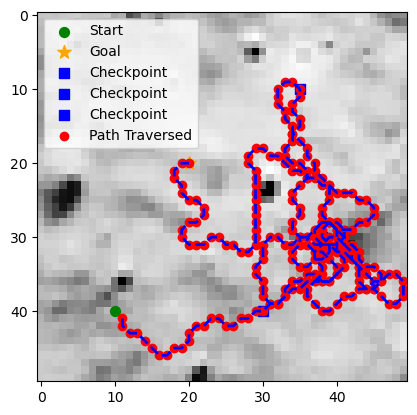

In [56]:
x_coords = [p.x for p in path]
y_coords = [p.y for p in path]

# Plot the image
plt.imshow(cropped_image, cmap="gray", interpolation="nearest")  # Load map if it's a grayscale image
plt.scatter(start[0], start[1], color="green", marker="o", s=50, label="Start")
plt.scatter(goal[0], goal[1], color="orange", marker="*", s=100, label="Goal")
for _ in range(len(checkpoints)-1):
    plt.scatter(checkpoints[_][0], checkpoints[_][1], color="blue", marker="s", s=50, label="Checkpoint")
plt.scatter(x_coords, y_coords, c='red', marker='o', label='Path Traversed')  # Mark path
plt.plot(x_coords, y_coords, c='blue', linestyle='dashed', linewidth=2)  # Connect path

# Show plot
plt.legend()
plt.savefig("plot.png", dpi=300)
plt.show()

## Animate the path of the Rover

In [57]:
'''
# Extract coordinates
x_coords = [p.x for p in path]
y_coords = [p.y for p in path]

fig, ax = plt.subplots()
plt.imshow(cropped_image, cmap="gray", interpolation="nearest")  # Load map if it's a grayscale image
plt.scatter(start[0], start[1], color="green", marker="o", s=50, label="Start")
plt.scatter(goal[0], goal[1], color="orange", marker="*", s=100, label="Goal")
for _ in range(len(checkpoints)-1):
    plt.scatter(checkpoints[_][0], checkpoints[_][1], color="blue", marker="s", s=50, label="Checkpoint")

path_dot, = ax.plot([], [], 'ro', label="Traversed")
path_line, = ax.plot([], [], 'b--', linewidth=2)

def init():
    path_dot.set_data([], [])
    path_line.set_data([], [])
    return path_dot, path_line

def update(frame):
    path_dot.set_data(x_coords[:frame], y_coords[:frame])
    path_line.set_data(x_coords[:frame], y_coords[:frame])
    return path_dot, path_line

ani = animation.FuncAnimation(fig, update, frames=len(path), init_func=init, blit=True, repeat=False)

# Save as GIF
# ani.save('agent_path.gif', writer='pillow', fps=10)

# Optional display
# plt.legend()
'''


'\n# Extract coordinates\nx_coords = [p.x for p in path]\ny_coords = [p.y for p in path]\n\nfig, ax = plt.subplots()\nplt.imshow(cropped_image, cmap="gray", interpolation="nearest")  # Load map if it\'s a grayscale image\nplt.scatter(start[0], start[1], color="green", marker="o", s=50, label="Start")\nplt.scatter(goal[0], goal[1], color="orange", marker="*", s=100, label="Goal")\nfor _ in range(len(checkpoints)-1):\n    plt.scatter(checkpoints[_][0], checkpoints[_][1], color="blue", marker="s", s=50, label="Checkpoint")\n\npath_dot, = ax.plot([], [], \'ro\', label="Traversed")\npath_line, = ax.plot([], [], \'b--\', linewidth=2)\n\ndef init():\n    path_dot.set_data([], [])\n    path_line.set_data([], [])\n    return path_dot, path_line\n\ndef update(frame):\n    path_dot.set_data(x_coords[:frame], y_coords[:frame])\n    path_line.set_data(x_coords[:frame], y_coords[:frame])\n    return path_dot, path_line\n\nani = animation.FuncAnimation(fig, update, frames=len(path), init_func=init, b